# 3IO-PCEX (IOPC)

Model 30IO-PCEX was introduced by Marco Veronese Passarella as a simple pedagogical model and intermediate step towards an environmentally extended stock-flow consistent (SFC) input-output (IO) model (see the [source repository](https://github.com/marcoverpas/keynote_speech_Florence/blob/main/README.md#21---model-pc)). This implementation by Karl Naumann-Woleske extends the model to use the expectation version of model PC.

## Module Contents

As with all `MacroStat` models, IOPC is divided into Variables, Parameters (fixed constants), Scenarios, and the Behavior (model initialization and steps). The module-level documentation, such as all variables/parameters/scenarios and their notation or the behavioral equations associated with each function of `BehaviorIOPC.py` can be seen in:

```{eval-rst}
.. toctree::
    :maxdepth: 2

    Variables <variables.rst>
    Parameters <parameters.rst>
    Equations <equations.rst>
    Scenarios <scenarios.rst>
```

For the full model API please check the [API Reference](../../api_reference)

## Model Overview

The remainder of this page gives an introduction to the model, notes on how it is implemented in `MacroStat` and then shows some of the model dynamics using the default parameters. 

### Transaction Flow Matrix

```{csv-table} Accounting Transaction Matrix for Model 3IO-PCEX
:file: transaction_matrix.csv
:header-rows: 2
:stub-columns: 1
```

### Balance Sheet Matrix

```{csv-table} Balance Sheet for Model 3IO-PCEX
:file: balance_sheet.csv
:header-rows: 2
:stub-columns: 1
```

## Model Dynamics

### Preparatory Steps

In [33]:
%load_ext autoreload
%autoreload 2

import importlib
import logging
import sys

# Import the necessary libraries for plotting
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

# Import the MacroStat get_model function
from macrostat.models import get_model
from macrostat.causality import DocstringCausalityAnalyzer

# Custom matplotlib style for the documentation
plt.style.use("../../macrostat.mplstyle")
# We show the logging output in the notebook
importlib.reload(logging)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Running the Simulation

First, we can run the model without any shocks to see the convergence to the steady state.

In [30]:
IOPCClass = get_model("IOPC")
model = IOPCClass()
model.simulate()
output = model.variables.to_pandas()

Here we can also check that the variables are healthy, which means that the redundant equations hold and that all the assets and liabilities are positive. For model PC, the redundant equation is that the household money stock equals the central bank money stock. 

:::{Note}
In numerical implementations, due to floating point precision it is unlikely that the redundant equation will hold exactly. Therefore, we check that the absolute percentage error is less than a given tolerance, in this case 1e-5. We use the absolute percentage error to appropriately scale the error for different magnitudes of the variables.
:::

In [4]:
model.variables.check_health(tolerance=1e-5)

True

### Convergence to the Steady State

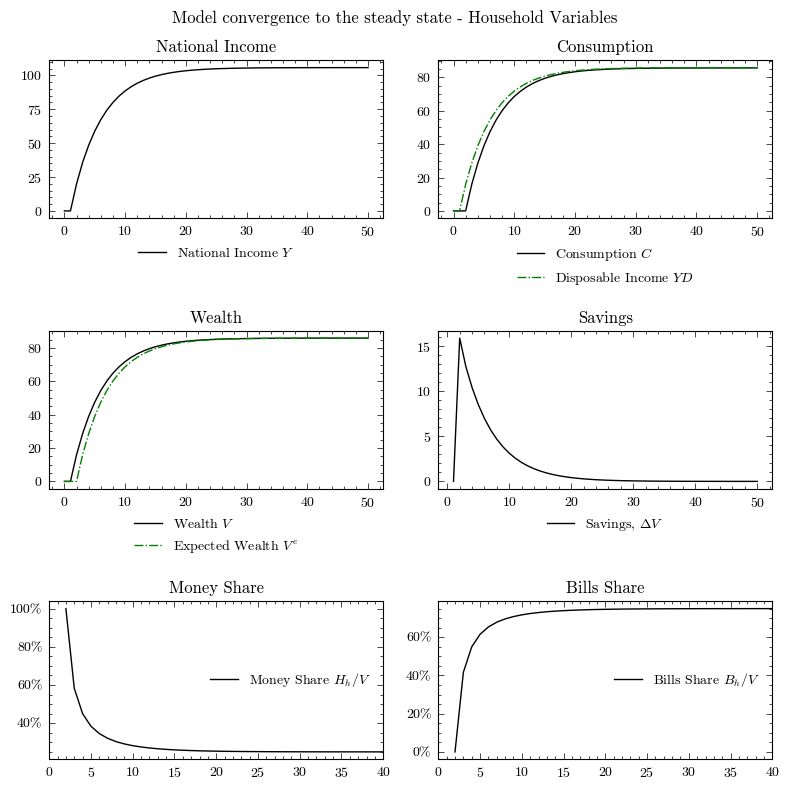

In [5]:
dfo = output.loc[:50]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(8, 8))

# National Income and Consumption
axs[0,0].plot(dfo.index, dfo['NationalIncome'], color='k', label=r'National Income $Y$')
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,0].set_title('National Income')
axs[0,1].plot(dfo.index, dfo['RealConsumptionHousehold'], color='k', label=r'Consumption $C$')
axs[0,1].plot(dfo.index, dfo['DisposableIncome'], color='g', linestyle='-.', label=r'Disposable Income $YD$')
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,1].set_title('Consumption')

# Wealth and Savings
axs[1,0].plot(dfo.index, dfo['Wealth'], color='k', label=r'Wealth $V$')
axs[1,0].plot(dfo.index, dfo['ExpectedWealth'], color='g', linestyle='-.', label=r'Expected Wealth $V^e$')
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,0].set_title('Wealth')
axs[1,1].plot(dfo.index, dfo['Wealth'].diff(), color='k', label=r'Savings, $\Delta V$')
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,1].set_title('Savings')

# Money Share and Bills Share
axs[2,0].plot(dfo.index, dfo['HouseholdMoneyStock'] / dfo['Wealth'], color='k', linestyle='-', label='Money Share $H_h/V$')
axs[2,0].legend(loc='center right', frameon=False)
axs[2,0].set_xlim(0,40)
axs[2,0].set_title('Money Share')
axs[2,0].yaxis.set_major_formatter(PercentFormatter(1))

# Right panel - Bills share
axs[2,1].plot(dfo.index, dfo['HouseholdBillStock'] / dfo['Wealth'], color='k', linestyle='-', label='Bills Share $B_h/V$')
axs[2,1].legend(loc='center right', frameon=False)
axs[2,1].set_xlim(0,40)
axs[2,1].set_title('Bills Share')
axs[2,1].yaxis.set_major_formatter(PercentFormatter(1))


fig.suptitle('Model convergence to the steady state - Household Variables')
plt.tight_layout()
plt.show()


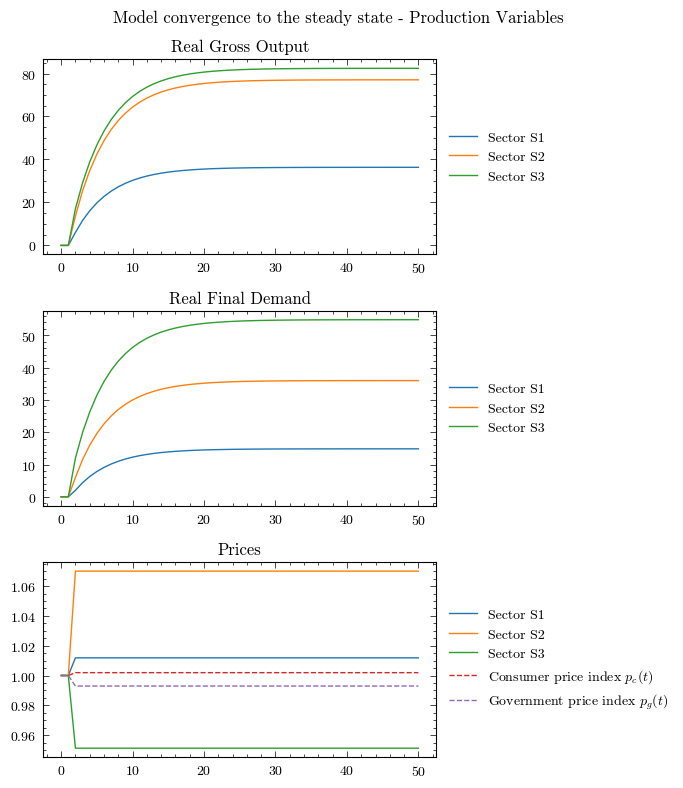

In [6]:
dfo = output.loc[:50]

fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(7, 8))

# National Income and Consumption
for s in dfo["RealGrossOutput"].columns:
    axs[0].plot(dfo.index, dfo['RealGrossOutput'][s], label=f"Sector {s}")
axs[0].set_title('Real Gross Output')

for s in dfo["RealFinalDemand"].columns:
    axs[1].plot(dfo.index, dfo['RealFinalDemand'][s], label=f"Sector {s}")
axs[1].set_title('Real Final Demand')

for s in dfo["Prices"].columns:
    axs[2].plot(dfo.index, dfo['Prices'][s], label=f"Sector {s}")
axs[2].plot(dfo.index, dfo["ConsumerPriceIndex"], linestyle="--", label=f"Consumer price index $p_c(t)$")
axs[2].plot(dfo.index, dfo["GovernmentPriceIndex"], linestyle="--", label=f"Government price index $p_g(t)$")
axs[2].set_title('Prices')

for ax in axs:
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)


fig.suptitle('Model convergence to the steady state - Production Variables')
plt.tight_layout()
plt.show()


### Perturbation 1: An increase of 100 points in the rate of interest on bills ($r$)

Following the convergence to the steady state, we can study the effects of an increase in the rate on bills by 100bps

`MacroStat` is set up to easily handle these scenarios. Much like in prior models, we simply define a new scenario `IncreaseInterestRate` and set the new rate to be 100 points higher $r=0.025+0.01$

In [10]:
model.parameters["scenario_trigger"] = 60
model.scenarios.add_scenario(
    name="IncreaseInterestRate",
    timeseries={"InterestRate":0.025 + 0.01}
)
model.simulate(scenario="IncreaseInterestRate")
output_rate_increase = model.variables.to_pandas()

Now we can see how the model reacts to the shock.

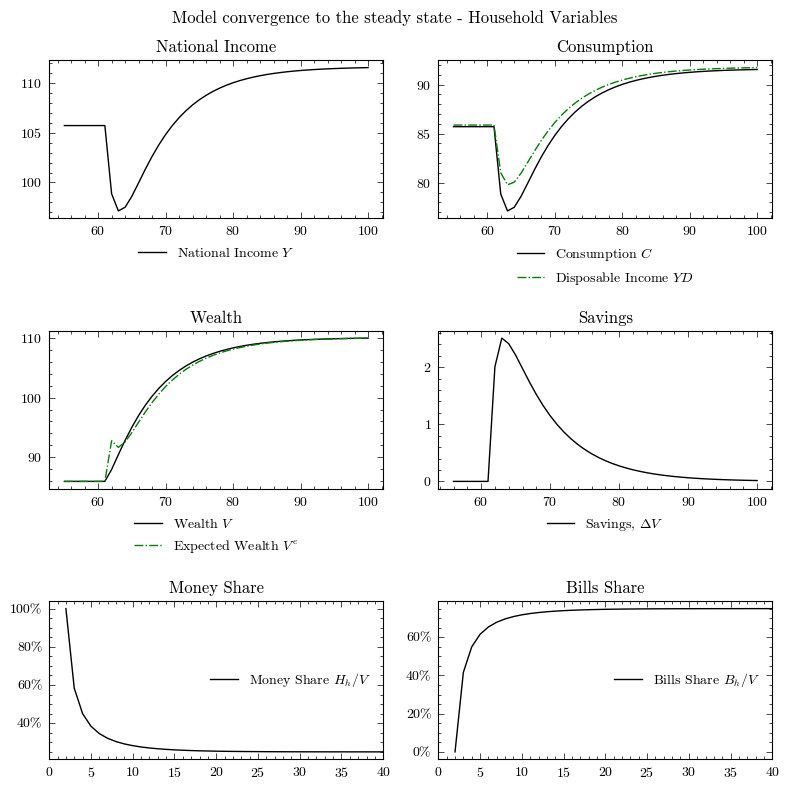

In [8]:
dfo = output_rate_increase.loc[55:]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(8, 8))

# National Income and Consumption
axs[0,0].plot(dfo.index, dfo['NationalIncome'], color='k', label=r'National Income $Y$')
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,0].set_title('National Income')
axs[0,1].plot(dfo.index, dfo['RealConsumptionHousehold'], color='k', label=r'Consumption $C$')
axs[0,1].plot(dfo.index, dfo['DisposableIncome'], color='g', linestyle='-.', label=r'Disposable Income $YD$')
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,1].set_title('Consumption')

# Wealth and Savings
axs[1,0].plot(dfo.index, dfo['Wealth'], color='k', label=r'Wealth $V$')
axs[1,0].plot(dfo.index, dfo['ExpectedWealth'], color='g', linestyle='-.', label=r'Expected Wealth $V^e$')
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,0].set_title('Wealth')
axs[1,1].plot(dfo.index, dfo['Wealth'].diff(), color='k', label=r'Savings, $\Delta V$')
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,1].set_title('Savings')

# Money Share and Bills Share
axs[2,0].plot(output.index, output['HouseholdMoneyStock'] / output['Wealth'], color='k', linestyle='-', label='Money Share $H_h/V$')
axs[2,0].legend(loc='center right', frameon=False)
axs[2,0].set_xlim(0,40)
axs[2,0].set_title('Money Share')
axs[2,0].yaxis.set_major_formatter(PercentFormatter(1))

# Right panel - Bills share
axs[2,1].plot(output.index, output['HouseholdBillStock'] / output['Wealth'], color='k', linestyle='-', label='Bills Share $B_h/V$')
axs[2,1].legend(loc='center right', frameon=False)
axs[2,1].set_xlim(0,40)
axs[2,1].set_title('Bills Share')
axs[2,1].yaxis.set_major_formatter(PercentFormatter(1))


fig.suptitle('Model convergence to the steady state - Household Variables')
plt.tight_layout()
plt.show()


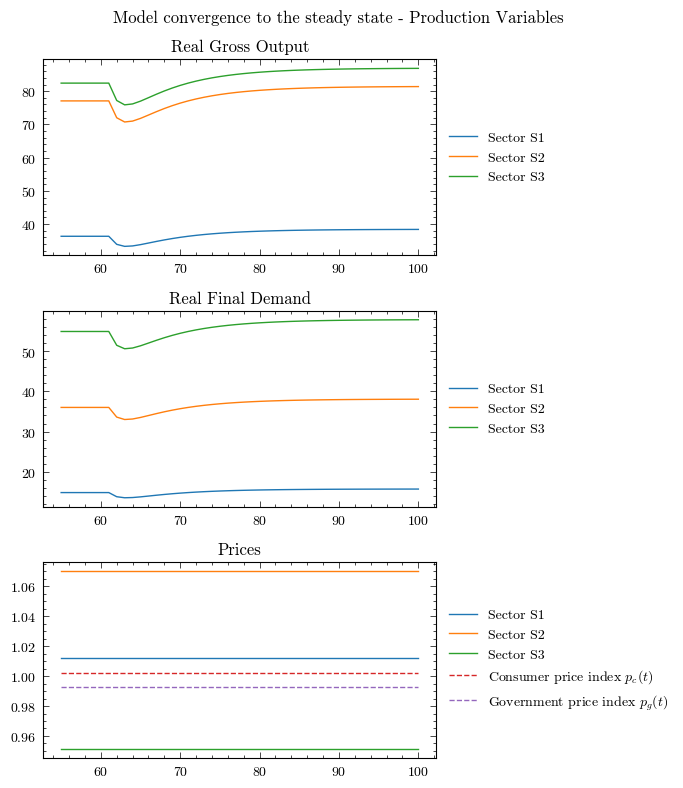

In [9]:
dfo = output_rate_increase.loc[55:]

fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(7, 8))

# National Income and Consumption
for s in dfo["RealGrossOutput"].columns:
    axs[0].plot(dfo.index, dfo['RealGrossOutput'][s], label=f"Sector {s}")
axs[0].set_title('Real Gross Output')

for s in dfo["RealFinalDemand"].columns:
    axs[1].plot(dfo.index, dfo['RealFinalDemand'][s], label=f"Sector {s}")
axs[1].set_title('Real Final Demand')

for s in dfo["Prices"].columns:
    axs[2].plot(dfo.index, dfo['Prices'][s], label=f"Sector {s}")
axs[2].plot(dfo.index, dfo["ConsumerPriceIndex"], linestyle="--", label=f"Consumer price index $p_c(t)$")
axs[2].plot(dfo.index, dfo["GovernmentPriceIndex"], linestyle="--", label=f"Government price index $p_g(t)$")
axs[2].set_title('Prices')

for ax in axs:
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)


fig.suptitle('Model convergence to the steady state - Production Variables')
plt.tight_layout()
plt.show()


### Perturbation 2: An increate in government spending

In [19]:
model.parameters["scenario_trigger"] = 60
model.scenarios.add_scenario(
    name="GovSpending",
    timeseries={"GovernmentDemand":25}
)
model.simulate(scenario="GovSpending")
output= model.variables.to_pandas()
dfo = output.loc[55:]

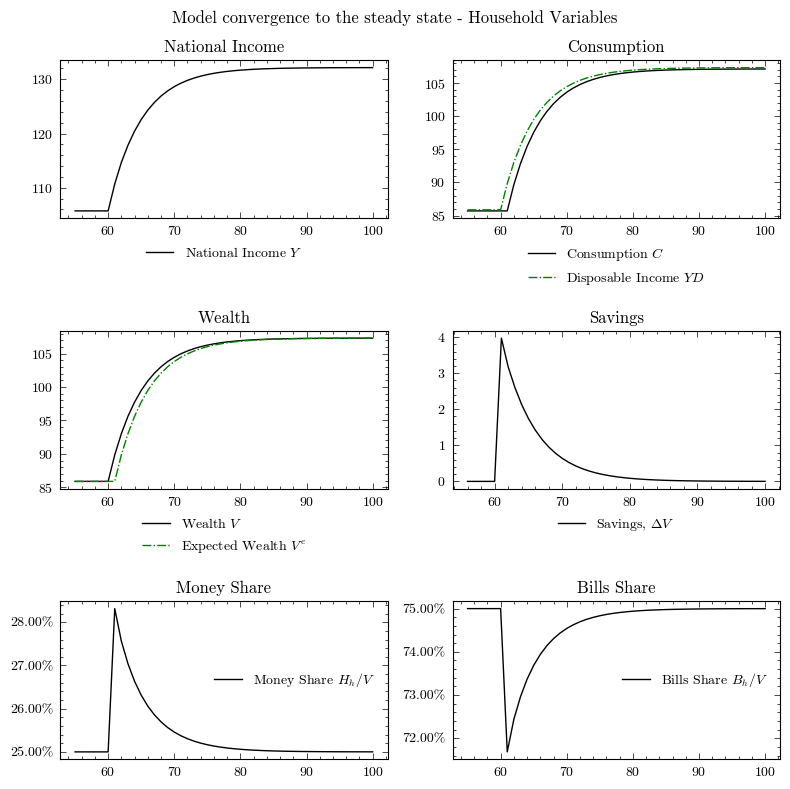

In [20]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(8, 8))

# National Income and Consumption
axs[0,0].plot(dfo.index, dfo['NationalIncome'], color='k', label=r'National Income $Y$')
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,0].set_title('National Income')
axs[0,1].plot(dfo.index, dfo['RealConsumptionHousehold'], color='k', label=r'Consumption $C$')
axs[0,1].plot(dfo.index, dfo['DisposableIncome'], color='g', linestyle='-.', label=r'Disposable Income $YD$')
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,1].set_title('Consumption')

# Wealth and Savings
axs[1,0].plot(dfo.index, dfo['Wealth'], color='k', label=r'Wealth $V$')
axs[1,0].plot(dfo.index, dfo['ExpectedWealth'], color='g', linestyle='-.', label=r'Expected Wealth $V^e$')
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,0].set_title('Wealth')
axs[1,1].plot(dfo.index, dfo['Wealth'].diff(), color='k', label=r'Savings, $\Delta V$')
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,1].set_title('Savings')

# Money Share and Bills Share
axs[2,0].plot(dfo.index, dfo['HouseholdMoneyStock'] / dfo['Wealth'], color='k', linestyle='-', label='Money Share $H_h/V$')
axs[2,0].legend(loc='center right', frameon=False)
axs[2,0].set_title('Money Share')
axs[2,0].yaxis.set_major_formatter(PercentFormatter(1))

# Right panel - Bills share
axs[2,1].plot(dfo.index, dfo['HouseholdBillStock'] / dfo['Wealth'], color='k', linestyle='-', label='Bills Share $B_h/V$')
axs[2,1].legend(loc='center right', frameon=False)
axs[2,1].set_title('Bills Share')
axs[2,1].yaxis.set_major_formatter(PercentFormatter(1))


fig.suptitle('Model convergence to the steady state - Household Variables')
plt.tight_layout()
plt.show()


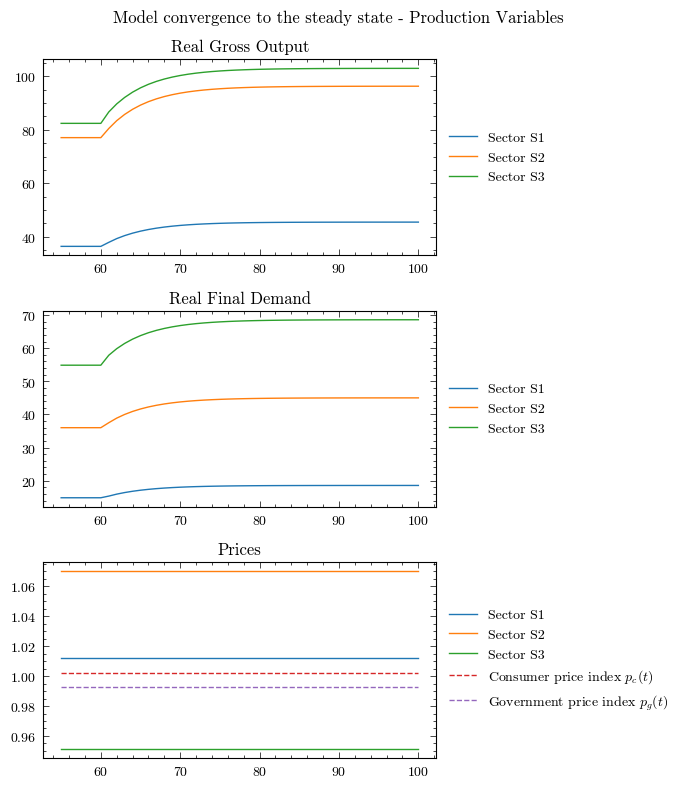

In [21]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(7, 8))

# National Income and Consumption
for s in dfo["RealGrossOutput"].columns:
    axs[0].plot(dfo.index, dfo['RealGrossOutput'][s], label=f"Sector {s}")
axs[0].set_title('Real Gross Output')

for s in dfo["RealFinalDemand"].columns:
    axs[1].plot(dfo.index, dfo['RealFinalDemand'][s], label=f"Sector {s}")
axs[1].set_title('Real Final Demand')

for s in dfo["Prices"].columns:
    axs[2].plot(dfo.index, dfo['Prices'][s], label=f"Sector {s}")
axs[2].plot(dfo.index, dfo["ConsumerPriceIndex"], linestyle="--", label=f"Consumer price index $p_c(t)$")
axs[2].plot(dfo.index, dfo["GovernmentPriceIndex"], linestyle="--", label=f"Government price index $p_g(t)$")
axs[2].set_title('Prices')

for ax in axs:
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)


fig.suptitle('Model convergence to the steady state - Production Variables')
plt.tight_layout()
plt.show()


### Perturbation 3: An increase in the wage rate

In [22]:
model.parameters["scenario_trigger"] = 60
model.scenarios.add_scenario(
    name="WageRate",
    timeseries={"WageRate":0.5}
)
model.simulate(scenario="WageRate")
output_wage_rate_increase = model.variables.to_pandas()
dfo = output_wage_rate_increase.loc[55:]

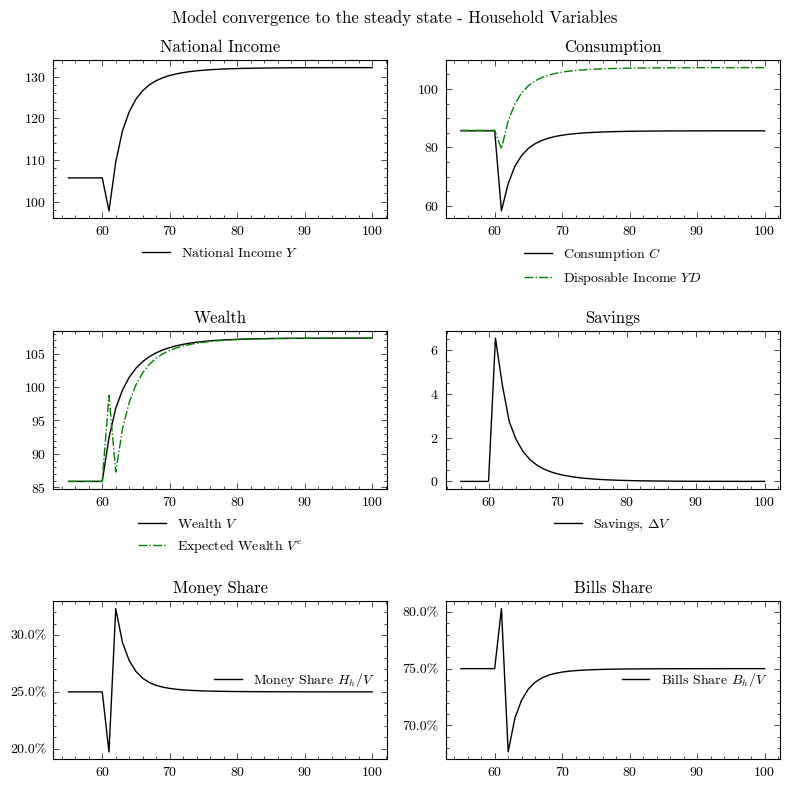

In [23]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(8, 8))

# National Income and Consumption
axs[0,0].plot(dfo.index, dfo['NationalIncome'], color='k', label=r'National Income $Y$')
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,0].set_title('National Income')
axs[0,1].plot(dfo.index, dfo['RealConsumptionHousehold'], color='k', label=r'Consumption $C$')
axs[0,1].plot(dfo.index, dfo['DisposableIncome'], color='g', linestyle='-.', label=r'Disposable Income $YD$')
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,1].set_title('Consumption')

# Wealth and Savings
axs[1,0].plot(dfo.index, dfo['Wealth'], color='k', label=r'Wealth $V$')
axs[1,0].plot(dfo.index, dfo['ExpectedWealth'], color='g', linestyle='-.', label=r'Expected Wealth $V^e$')
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,0].set_title('Wealth')
axs[1,1].plot(dfo.index, dfo['Wealth'].diff(), color='k', label=r'Savings, $\Delta V$')
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,1].set_title('Savings')

# Money Share and Bills Share
axs[2,0].plot(dfo.index, dfo['HouseholdMoneyStock'] / dfo['Wealth'], color='k', linestyle='-', label='Money Share $H_h/V$')
axs[2,0].legend(loc='center right', frameon=False)
axs[2,0].set_title('Money Share')
axs[2,0].yaxis.set_major_formatter(PercentFormatter(1))

# Right panel - Bills share
axs[2,1].plot(dfo.index, dfo['HouseholdBillStock'] / dfo['Wealth'], color='k', linestyle='-', label='Bills Share $B_h/V$')
axs[2,1].legend(loc='center right', frameon=False)
axs[2,1].set_title('Bills Share')
axs[2,1].yaxis.set_major_formatter(PercentFormatter(1))


fig.suptitle('Model convergence to the steady state - Household Variables')
plt.tight_layout()
plt.show()


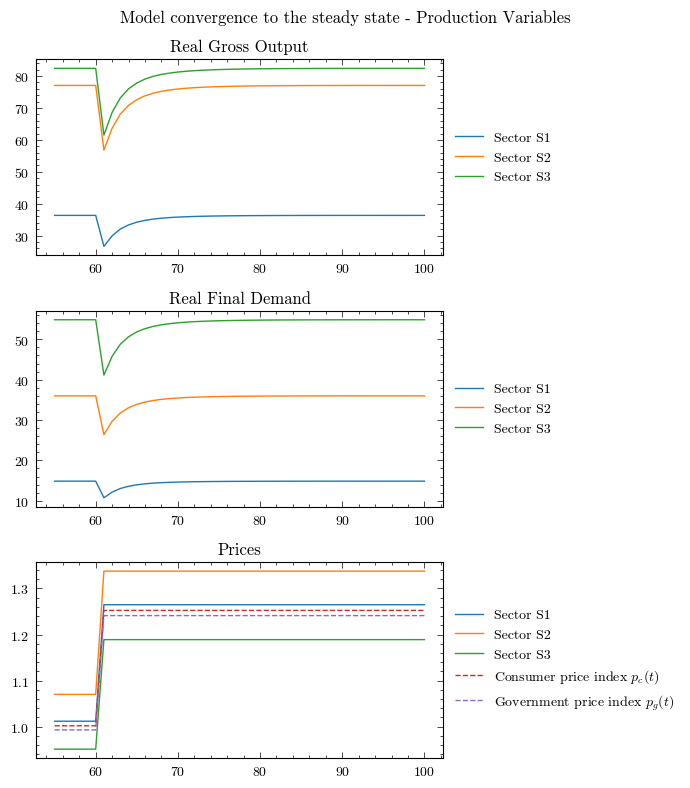

In [24]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(7, 8))

# National Income and Consumption
for s in dfo["RealGrossOutput"].columns:
    axs[0].plot(dfo.index, dfo['RealGrossOutput'][s], label=f"Sector {s}")
axs[0].set_title('Real Gross Output')

for s in dfo["RealFinalDemand"].columns:
    axs[1].plot(dfo.index, dfo['RealFinalDemand'][s], label=f"Sector {s}")
axs[1].set_title('Real Final Demand')

for s in dfo["Prices"].columns:
    axs[2].plot(dfo.index, dfo['Prices'][s], label=f"Sector {s}")
axs[2].plot(dfo.index, dfo["ConsumerPriceIndex"], linestyle="--", label=f"Consumer price index $p_c(t)$")
axs[2].plot(dfo.index, dfo["GovernmentPriceIndex"], linestyle="--", label=f"Government price index $p_g(t)$")
axs[2].set_title('Prices')

for ax in axs:
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)


fig.suptitle('Model convergence to the steady state - Production Variables')
plt.tight_layout()
plt.show()
